<a href="https://colab.research.google.com/github/Takfes/notes-reinforcement-learning/blob/main/notebooks/002_frozenlake_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
sudo apt-get update
apt install swig cmake
pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit1/requirements-unit1.txt

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,482 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.7 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-secur

In [104]:
%%bash
apt install python3-opengl
apt install ffmpeg
apt install xvfb
pip3 install pyvirtualdisplay

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  freeglut3 libglu1-mesa
Suggested packages:
  libgle3 python3-numpy
The following NEW packages will be installed:
  freeglut3 libglu1-mesa python3-opengl
0 upgraded, 3 newly installed, 0 to remove and 47 not upgraded.
Need to get 824 kB of archives.
After this operation, 8,092 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 freeglut3 amd64 2.8.1-6 [74.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglu1-mesa amd64 9.0.2-1 [145 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 python3-opengl all 3.1.5+dfsg-1 [605 kB]
Fetched 824 kB in 1s (567 kB/s)
Selecting previously unselected package freeglut3:amd64.
(Reading database ... 122678 files and directories currently installed.)
Preparing to unpack .../freeglut3_2.8.1-6_amd64.deb ...
Unpacking freeglut3:amd64 (2.8.1-6) ...

In [ ]:
# import os
# os.kill(os.getpid(), 9)

In [105]:
# Virtual display
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
!python -m pip install pygame

In [ ]:
from IPython import display as ipythondisplay

## Q Learning
* Update Rule : $Q(s,a) ← Q(s,a) + α (r + γ * max_{a′}Q(s′,a′)−Q(s,a))$
* Update Rule : $NewEstimate ← OldEstimate + StepSize * [Target - OldEstimate]$
* [Frozen Lake Youtube](https://www.youtube.com/watch?v=ZhoIgo3qqLU)

In [52]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [139]:
episodes = 30_000
discount_rate_g = 0.9
learning_rate_a = 0.9
epsilon = 1
epsilon_decay = 0.0001
epsilon_min = 0
print(f"Episodes till epsilon decays : {epsilon/epsilon_decay:,.0f}")

Episodes till epsilon decays : 10,000


In [140]:
def qlearning(episodes, render = False, qtable = None,
              discount_rate_g = 0.9, learning_rate_a = 0.9,
              epsilon = 1, epsilon_decay = 0.0001, epsilon_min = 0.0,
              ):

    # CONFIGURE THE ENVIRONMENT HERE
    # setup environment
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='rgb_array' if render else None)

    # initialization
    if qtable is None:
        qtable = np.zeros((env.observation_space.n, env.action_space.n))
        is_training = True
    else:
        assert qtable.shape == (env.observation_space.n, env.action_space.n), "qtable shape does not match env"
        is_training = False

    rewards = np.zeros(episodes)

    # training loop over episodes
    for episode in range(episodes):

        # reset environment
        state, _ = env.reset()
        terminated, truncated = False, False

        # while loop to train for each episode
        while not(terminated or truncated):

            # epsilon-greedy selection
            if (is_training) and (np.random.random() < epsilon):
                action = env.action_space.sample()
            else:
                action = np.argmax(qtable[state,:])

            # action
            new_state, reward, terminated, truncated, info = env.step(action)

            # visualize environment
            if render:
                screen = env.render()
                plt.imshow(screen)
                ipythondisplay.clear_output(wait=True)
                # ipythondisplay.display(plt.gcf())
                plt.pause(0.5)

            # update qtable
            if is_training:
                qtable[state, action] = qtable[state, action] + learning_rate_a * (
                    reward + discount_rate_g * np.max(qtable[new_state,:]) - qtable[state, action])

            # update current state
            state = new_state

        # epsilon decay
        epsilon = max(epsilon - epsilon_decay, epsilon_min)

        # stabilize learning rate after epsilon has decayed
        if (epsilon == 0):
            learning_rate_a = 0.001

        # save rewards if successful, already initialized to 0
        if (reward==1):
            rewards[episode] = 1

    # close the environment
    env.close()

    return qtable, rewards

In [141]:
%%time
qtable, rewards = qlearning(episodes = episodes, discount_rate_g = discount_rate_g, learning_rate_a = learning_rate_a,
                            epsilon = epsilon, epsilon_decay = epsilon_decay, epsilon_min = epsilon_min)

CPU times: user 34.4 s, sys: 2.29 s, total: 36.7 s
Wall time: 38.4 s


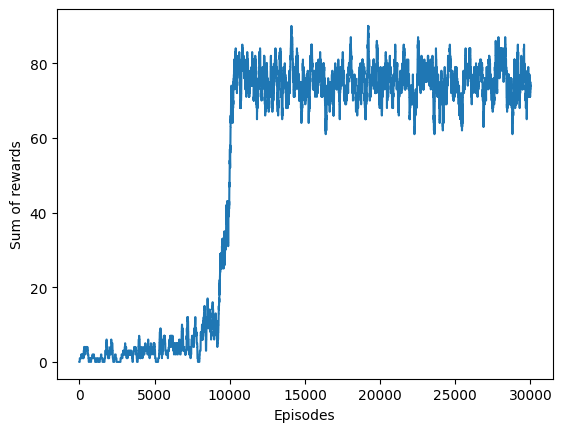

In [142]:
# plot progress
sum_rewards = np.zeros(episodes)
for i in range(episodes):
    sum_rewards[i] = np.sum(rewards[max(0,i-100):(i+1)])
plt.plot(sum_rewards)
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards")
plt.show()

In [143]:
# show qtable
qdf = pd.DataFrame(qtable,columns = ['0: Move left','1: Move down','2: Move right','3: Move up'])
qdf.assign(Move=lambda x: x.idxmax(axis=1))

,0: Move left,1: Move down,2: Move right,3: Move up,Move
0,0.068340,5.047923e-03,0.004074,3.953392e-03,0: Move left
1,0.000136,5.011447e-05,0.000010,4.187142e-02,3: Move up
2,0.000132,5.609772e-05,0.000126,2.795242e-02,3: Move up
3,0.000127,2.664918e-05,0.000058,2.194827e-02,3: Move up
4,0.090747,6.727283e-03,0.000163,7.284136e-04,0: Move left
5,0.000000,0.000000e+00,0.000000,0.000000e+00,0: Move left
6,0.000003,6.504903e-07,0.100297,3.766047e-10,2: Move right
7,0.000000,0.000000e+00,0.000000,0.000000e+00,0: Move left
8,0.013344,3.330353e-06,0.000105,1.416478e-01,3: Move up
9,0.000803,2.481671e-01,0.000122,1.338596e-03,1: Move down


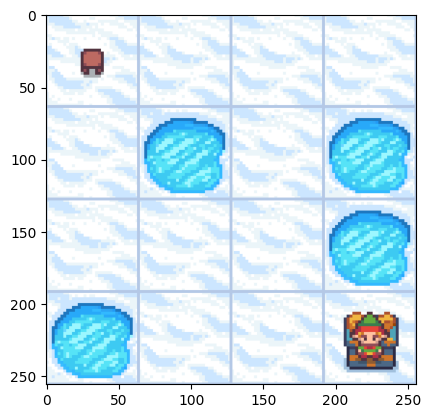

In [144]:
qlearning(episodes = 1, qtable= qtable, render=True);